# TensorFlow on Abstracts of Multiple Subjects from August 2017 Training Data 
In this notebook, a recurrent neural network is used to identify disciplines from journal abstracts. Using a RNN is useful and more accurate since information about the *sequence* of the words is used. For this project, a dataset of titles (features) and subjects (labels) from scientific papers is used for the RNN training. This RNN uses an *embedding layer* for a more efficient representation of the vocabulary. This new representation of words from the embedding layer is then passed to Long-Short Term Memory (LSTM) cells, which adds recurrent connections to the newtork.

## Import Main Libraries

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
!pip install --upgrade nltk
#import nltk
#nltk.download('popular')

Requirement already up-to-date: nltk in /home/carnd/anaconda3/lib/python3.5/site-packages
Requirement already up-to-date: six in /home/carnd/anaconda3/lib/python3.5/site-packages (from nltk)
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Import Data and Preprocess
The original data files are from the Google shared drive. They are either from Roxana or Diego. The first training set, 'arxiv_train_set', was modified to include column labels ('Titles' and 'Labels') and saved as a csv file using Excel. The second training set provided by Diego also contains information about character counts, term counts, review, and references. 

In [3]:
data = pd.read_csv('2017_09_14_diego_numerical_data_abstracts.csv', encoding='latin1') ## Encoding of latin1 helps eliminate reading errors
data.shape ## Inspect data structure

(13106, 7)

In [4]:
# Define titles and labels 
#abstracts = data.Abstracts.astype(str)
#labels = data.Labels.astype(str)

# Simplify number of classes
data['class'] = data['category'].apply(lambda x: x.split('.')[0])

abstracts = data.abstract.astype(str)
labels = data['class'].astype(str)

# Inspect titles
abstracts[0]

'We present a semi-analytical model of star formation which explains simultaneously the observed UV luminosity function of high redshift Lyman break galaxies (LBGs) and luminosity functions of Lyman-alpha emitters. We consider both models that use the Press-Schechter (PS) and Sheth-Tormen (ST) halo mass functions to calculate the abundances of dark matter halos. The Lyman-alpha luminosity functions at z < 4 are well reproduced with only <10% of the LBGs emitting Lyman-alpha lines with rest equivalent width greater than the limiting equivalent width of the narrow band surveys. However, the observed luminosity function at z > 5 can be reproduced only when we assume that nearly all LBGs are Lyman-alpha emitters. Thus it appears that 4 < z < 5 marks the epoch when a clear change occurs in the physical properties of the high redshift galaxies. As Lyman-alpha escape depends on dust and gas kinematics of the inter stellar medium (ISM), this could mean that on an average the ISM at z > 5 could

### Cleaning Abstracts
As shown in the abstract example, there are capitilazations, punctuations, and formatting issues that need to be cleaned up before creating an embedding layer. Hyphenated words, for now, will be made into one word. It may be useful to reconsider this approach on hyphenated words if it is necessary to improve accuracies. 

In [5]:
## Clean up abstracts
import re
from string import punctuation
#from nltk.stem import WordNetLemmatizer

abstracts = abstracts.replace('\r', '', regex=True) ## Remove '\r'
abstracts = abstracts.replace('-', ' ', regex=True) ## Remove hyphenated words

#wnl = WordNetLemmatizer()
abstracts_clean = []
for row in abstracts:
    #row = [wnl.lemmatize(word) for word in row.split()]
    #row = ' '.join(row)
    row = row.lower() ## Put all text into lowercase
    row = ''.join([c for c in row if c not in punctuation]) ## Remove punctuation
    row = ''.join([c for c in row if not c.isdigit()]) ## Remove numbers
    abstracts_clean.append(row)
    
## Inspect clean titles
abstracts_clean[0]

'we present a semi analytical model of star formation which explains simultaneously the observed uv luminosity function of high redshift lyman break galaxies lbgs and luminosity functions of lyman alpha emitters we consider both models that use the press schechter ps and sheth tormen st halo mass functions to calculate the abundances of dark matter halos the lyman alpha luminosity functions at z   are well reproduced with only  of the lbgs emitting lyman alpha lines with rest equivalent width greater than the limiting equivalent width of the narrow band surveys however the observed luminosity function at z   can be reproduced only when we assume that nearly all lbgs are lyman alpha emitters thus it appears that   z   marks the epoch when a clear change occurs in the physical properties of the high redshift galaxies as lyman alpha escape depends on dust and gas kinematics of the inter stellar medium ism this could mean that on an average the ism at z   could be less dusty more clumpy an

### Creating vocaublary and transforming words into integers
This step is necessary for TensorFlow to work with words of the abstracts in a numerical manner. All words are given a specific *token* that is used to give them a numeric presence. The value of the token does not necesarilly correlate with the length, frequency, or position of the respective word. However, it is common to sort the words by frequency to have a way to apply cutoffs in the vocabulary if needed to imporve training accuracies. An inversion dictionary was added to convert integers back to words.

In [6]:
# Change title words to integers
from collections import Counter

all_text = ' '.join(abstracts_clean) ## Create compiled text
words = all_text.split() ## Create list of all words

counts = Counter(words) ## Count the occurence of each word
vocab = sorted(counts, key=counts.get, reverse=True) ## Sorted words by occurence
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)} ## Conversion dictionary
int_to_vocab = {ii: word for ii, word in enumerate(vocab, 1)} ## Inversion dictionary

abstracts_ints = [] ## Empty titles list for integer encoding
# Introduce word frequency cutoffs for analysis
for abstract in abstracts_clean:
    abstracts_ints.append([vocab_to_int[word] if counts[word] > 0 and counts[word] < 4000 \
                           else 0 for word in abstract.split()]) ## Label 0 words outside cutoffs
    
# Remove elements in rows with 0    
for ii in range(len(abstracts_ints)):
    abstracts_ints[ii] = list(filter((0).__ne__, abstracts_ints[ii]))
# Inspect titles_ints
#abstracts_ints[0]
#vocab[len(vocab)-100:len(vocab)-90] ## Inspect least common words


In [7]:
data['class'].value_counts()

cs          3306
math        3204
physics     2091
cond-mat     904
q-bio        800
astro-ph     596
nlin         505
stat         501
q-fin        301
math-ph      102
hep-ex       101
gr-qc        100
hep-lat      100
quant-ph     100
hep-ph       100
nucl-th       99
hep-th        98
nucl-ex       98
Name: class, dtype: int64

### Subset data and one-hot-encode subjects
In this section the data can be subseted in order to control the number of subjects to be analyzed. NOTE: For this case, subjects for a given field are being lumped together in one catergory. That is, all subjects of astrophysics are being encoded to fit in the astrophysics group and so forth. This results in 13 distinct 'subjects' to be analyzed in this notebook.

In [8]:
# Create subset for titles and subjects if needed
sub_idx = 13106 ## Subset final index
abstracts_ints_sub = abstracts_ints[:sub_idx] ## Titles ints subset
labels_sub = labels[:sub_idx] ## Subject subset

# Encode 13 "subjects" (disciplines) from text to numbers
#labels_class_sub = np.array([1 if 'astro' in label else 2 if 'physics.' in label\
                            #else 1 if 'gr-' in label else 2 if 'hep' in label\
                            #else 5 if 'math' in label else 6 if 'nlin.' in label\
                            #else 2 if 'nucl-' in label else 2 if 'cond-mat.' in label\
                            #else 9 if 'q-bio.' in label else 10 if 'q-fin.' in label\
                            #else 2 if 'quant-ph' in label else 5 if 'stat.' in label
                            #else 0 for label in labels_sub]) 
                            ## cs has to be labeled 0 to avoid overlap w/ physics

#print(np.unique(labels_class_sub)) ## check which subjects are being identified

# One hot encode of subjects 
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(labels_sub)
labels_ints_sub = lb.transform(labels_sub)
type(labels_ints_sub)
len(labels_ints_sub)

13106

### Modulate abstract length
This section of code helps modulate the minimum abstract length in words that will be analyzed. 

In [9]:
# Make a cutoff for minimum abstract length
min_abstract_length = 1 ## Minimum number of words needed
# Find index for row with abstracts greater than minimum words
non_min_idx = [ii for ii, abstract in enumerate(abstracts_ints_sub) if len(abstract) >= min_abstract_length]

# Further subset the asbtracts and labels 
abstracts_ints_sub = [abstracts_ints_sub[ii] for ii in non_min_idx]
labels_ints_sub = np.array([labels_ints_sub[ii] for ii in non_min_idx])

len(labels_ints_sub)

13106

### Find longest title and create titles matrix with corresponding dimensions
It is necessary to find the longest title from the subset in order to determine the number of columns necessary in titles matrix. In cases where the titles are shorter, it is necessary to pad the empty locations in a given row with zeros. All rows are filled from right to left so the padding of zeros occurs prior to each sentence of integers.

In [10]:
# Find length of abstracts
len_abstracts = []
for i in np.arange(0, len(abstracts_ints_sub), 1):
    len_abstracts.append(len(abstracts_ints_sub[i]))

# Create a matrix of titles
seq_len = max(len_abstracts) ## max(len_abstracts)
print(seq_len)
features = np.zeros((len(abstracts_ints_sub), seq_len), dtype=int)
for i, row in enumerate(abstracts_ints_sub):
    features[i, -len(row):] = np.array(row)[:seq_len]
    
# Inspect features
features.shape

226


(13106, 226)

### Shuffle and split the data into training, validation, and test sets
First, a function is created to do a shuffle-split of the data. Next, a training set of 80% of the original dataset is created. The remaning 20% of the original data is split evenly to create a validation set for model optimization and a test set for final testing. It is important to shuffle the original dataset since it was listed in order of subjects. This is the last preprocessing step necessary to feed our data into TensorFlow.

In [137]:
# Iterate through different sample sizes
samples = []
for i in range(2, 19):
    classes = data['class'].value_counts().index.tolist()[:i]
    indices = data.index[data['class'].isin(classes)].tolist()
    samples.append(len(indices))
print(samples)

[6510, 8601, 9505, 10305, 10901, 11406, 11907, 12208, 12310, 12411, 12511, 12611, 12711, 12811, 12910, 13008, 13106]


In [123]:
# Function to shuffl and split original dataset
from sklearn import model_selection

num_test = int(0.2 * len(abstracts_ints_sub))

def shuffle_split(X, y):
    
    ss = model_selection.ShuffleSplit(test_size=num_test)
    
    for train_index, test_index in ss.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
    return X_train, y_train, X_test, y_test

In [124]:
# Create first split for training and test sets
X_train, y_train, X_test, y_test = shuffle_split(features[indices], labels_ints_sub[indices])

# Split test set to validation and final test sets
test_idx = int(len(y_test)*0.5)
X_val, y_val = X_test[test_idx:], y_test[test_idx:] ## For validation
X_tst, y_tst = X_test[:test_idx], y_test[:test_idx] ## For final testing

# Print final shapes
print('\t\t\tFeature Shapes:')
print('Train set: \t\t{}'.format(X_train.shape),
     '\nValidation set: \t{}'.format(X_val.shape),
     '\nTest set: \t\t{}'.format(X_tst.shape))

			Feature Shapes:
Train set: 		(10485, 226) 
Validation set: 	(1311, 226) 
Test set: 		(1310, 226)


## Build the TensorFlow Graph
Here, we'll build the graph. TensorFlow represents computations as a graph composed of nodes, where a node in a graph is an operation that converts zero or more Tensors and computes zero or more Tensors. 

First up, defining the hyperparameters.

* `lstm_size`: Number of units in the hidden layers in the LSTM cells. Usually larger is better performance wise. Common values are 128, 256, 512, etc.
* `lstm_layers`: Number of LSTM layers in the network. One is a good starting point and this code needs to be updated to add more lstm_layer. Therefore, we will keep one layer fixed for now.
* `batch_size`: The number of titles to feed the network in one training pass. Typically this should be set as high as you can go without running out of memory.
* `learning_rate`: Learning rate determines how "quickly" the optimizers will explore the solution space. 

In [125]:
# Key hyperparameters
lstm_size = 128
lstm_layers = 1
batch_size = 100
learning_rate = 0.01

### Define constants and initialize input placeholders
Constants descriptive of the dataset need to be defined for later use in the training. Also, in TensorFlow it is necessary to create *placeholders* for inputs into the model. 

In [126]:
# Constants needed to account for data properties
n_words = len(vocab_to_int)
n_classes = y_train.shape[1]

# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs') ## Titles
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels') ## Subjects
    keep_prob = tf.placeholder(tf.float32, name='keep_prob') ## Drop probablity during training

### Create embedding layer
It is inefficient to one-hot encode all words in the vocabulary. Therefore, an embedding lookup matrix is created to get the embedded vectors to pass to the LSTM cell. 

In [127]:
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 300 

with graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1)) ## Lookup matrix
    embed = tf.nn.embedding_lookup(embedding, inputs_) ## Pass embedding 

### Build LSTM cell and run data through RNN nodes
An LSTM cell is created with dropout and the possibility of adding multiple layers if needed. The final 'cell' is then sent through the RNN nodes with *dynamic_rnn*, where TensorFlow takes care of the unrolling and time step computations.

In [128]:
with graph.as_default():
    # Your basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

In [129]:
with graph.as_default():
    # Run cell through RNN
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed,
                                             initial_state=initial_state)

### Calculate predictions and validation accuracy from outputs
By using the final outputs, it is possible then to predict the subjects for each title. To gauage the accuracy of the RNN, a validation accuracy is determined using the validation set. 

In [130]:
# Create predictions and calculate and optimize cost
with graph.as_default():
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], n_classes, activation_fn=tf.sigmoid)
    print(predictions) ## Check dimensions; need to match bath size and subject types
    cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Tensor("fully_connected/Sigmoid:0", shape=(100, 18), dtype=float32)


In [131]:
# Calculate accuracy for validation 
with graph.as_default():
    #correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    # Need to account for multiple classifiers
    correct_pred = tf.equal((tf.arg_max(tf.round(predictions), 1)), (tf.arg_max(labels_, 1)))    
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Make batches and train RNN
Create a function to create batchs of arbitrary size and igoner any entries left over. These batches will then be used to train the RNN and validate accuracy on the validation sets. A checkpoint file is created to record the neural network training and then can be used on the final test set. 

In [132]:
# Function to create batches
def get_batches(x, y, batch_size=10):
    
    n_batches = len(x)//batch_size ## Removes left over rows
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [133]:
# Typical trainig code for TensorFlow

epochs = 20 ## Number of full iterations

with graph.as_default():
    saver = tf.train.Saver()
losses = [] ## Keep track of training losses for plotting later
val_acc = [] ## Keep track of validation accuracy for plotting later
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(X_train, y_train, batch_size), 1):
            feed = {inputs_: x,
                    labels_: np.array(y),
                    keep_prob: 0.5,
                    initial_state: state}
            
            loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)
            losses.append(loss)
            if iteration%100==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))
            if iteration%100==0:
                
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(X_val, y_val, batch_size):
                    feed = {inputs_: x,
                            labels_: np.array(y),
                            keep_prob: 1,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
            iteration +=1

    saver.save(sess, "checkpoints/abstracts.ckpt")

Epoch: 0/20 Iteration: 100 Train loss: 0.050
Val acc: 0.061
Epoch: 1/20 Iteration: 200 Train loss: 0.034
Val acc: 0.163
Epoch: 2/20 Iteration: 300 Train loss: 0.032
Val acc: 0.235
Epoch: 3/20 Iteration: 400 Train loss: 0.023
Val acc: 0.269
Epoch: 4/20 Iteration: 500 Train loss: 0.021
Val acc: 0.297
Epoch: 5/20 Iteration: 600 Train loss: 0.020
Val acc: 0.312
Epoch: 6/20 Iteration: 700 Train loss: 0.015
Val acc: 0.324
Epoch: 7/20 Iteration: 800 Train loss: 0.017
Val acc: 0.332
Epoch: 8/20 Iteration: 900 Train loss: 0.019
Val acc: 0.342
Epoch: 9/20 Iteration: 1000 Train loss: 0.014
Val acc: 0.354
Epoch: 10/20 Iteration: 1100 Train loss: 0.014
Val acc: 0.362
Epoch: 11/20 Iteration: 1200 Train loss: 0.014
Val acc: 0.369
Epoch: 12/20 Iteration: 1300 Train loss: 0.011
Val acc: 0.370
Epoch: 13/20 Iteration: 1400 Train loss: 0.017
Val acc: 0.374
Epoch: 14/20 Iteration: 1500 Train loss: 0.015
Val acc: 0.377
Epoch: 15/20 Iteration: 1600 Train loss: 0.011
Val acc: 0.381
Epoch: 16/20 Iteration: 170

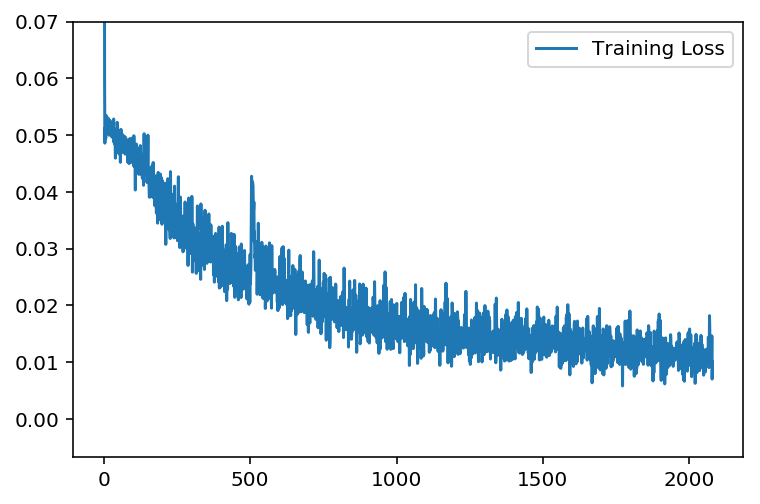

In [134]:
plt.plot(losses, label='Training Loss')
plt.legend()
plt.ylim(ymax=0.07)
plt.show()


with open('128_1_300_14_loss.csv', 'w') as file_handler:
    for item in losses:
        file_handler.write("{}\n".format(item))
        

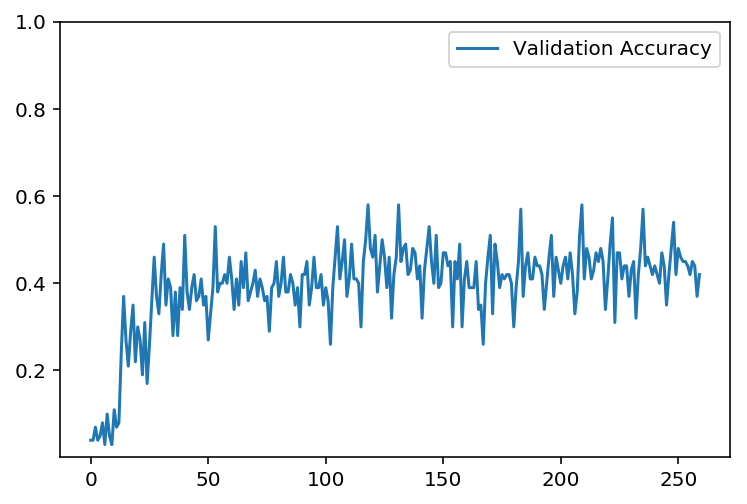

In [135]:
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylim(ymax=1.0)
plt.show()

with open('128_1_300_14_acc.csv', 'w') as file_handler:
    for item in val_acc:
        file_handler.write("{}\n".format(item))
        

### Test RNN on final test set
This code runs final test set to determing final accuracy of trained RNN network. It is important to have a directory where the checkpoint file may be stored for this last testing step.

In [136]:
#accuracies = [0.849]
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(X_tst, y_tst, batch_size), 1):
        feed = {inputs_: x,
                labels_: y,
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))
    accuracies.append(np.mean(test_acc))
    print(accuracies)

Test accuracy: 0.414
[0.849, 0.81153846, 0.71923071, 0.61076921, 0.56923074, 0.49923074, 0.54153848, 0.41384616]


## Plot overall performance trends and embedding matrix

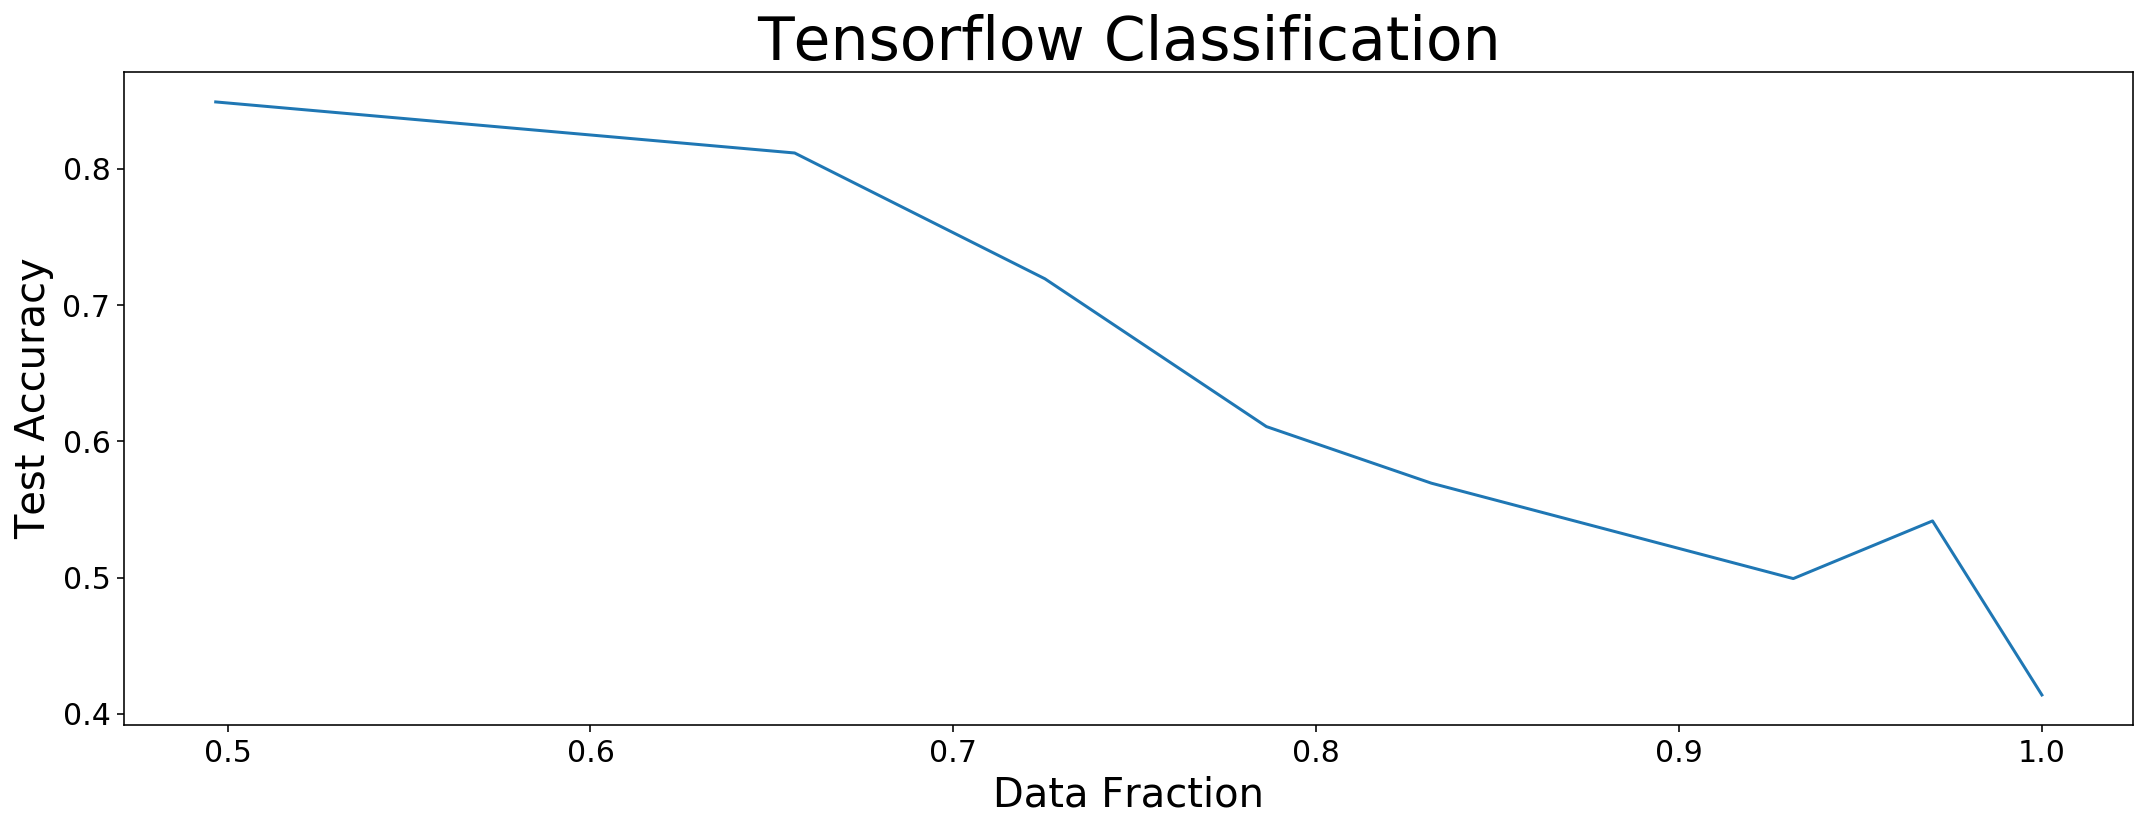

In [140]:
# Manual record of values
samples = np.array([6510, 8601, 9505, 10305, 10901, 12208, 12711, 13106]) / 13106
accuracies = [0.849, 0.81153846, 0.71923071, 0.61076921, 0.56923074, 0.49923074, 0.54153848, 0.41384616]

# Plot
plt.figure(figsize = (18, 6))
plt.plot(samples, accuracies)
plt.title('Tensorflow Classification', fontsize=30)
plt.xlabel('Data Fraction', fontsize=20)
plt.ylabel('Test Accuracy', fontsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.show()

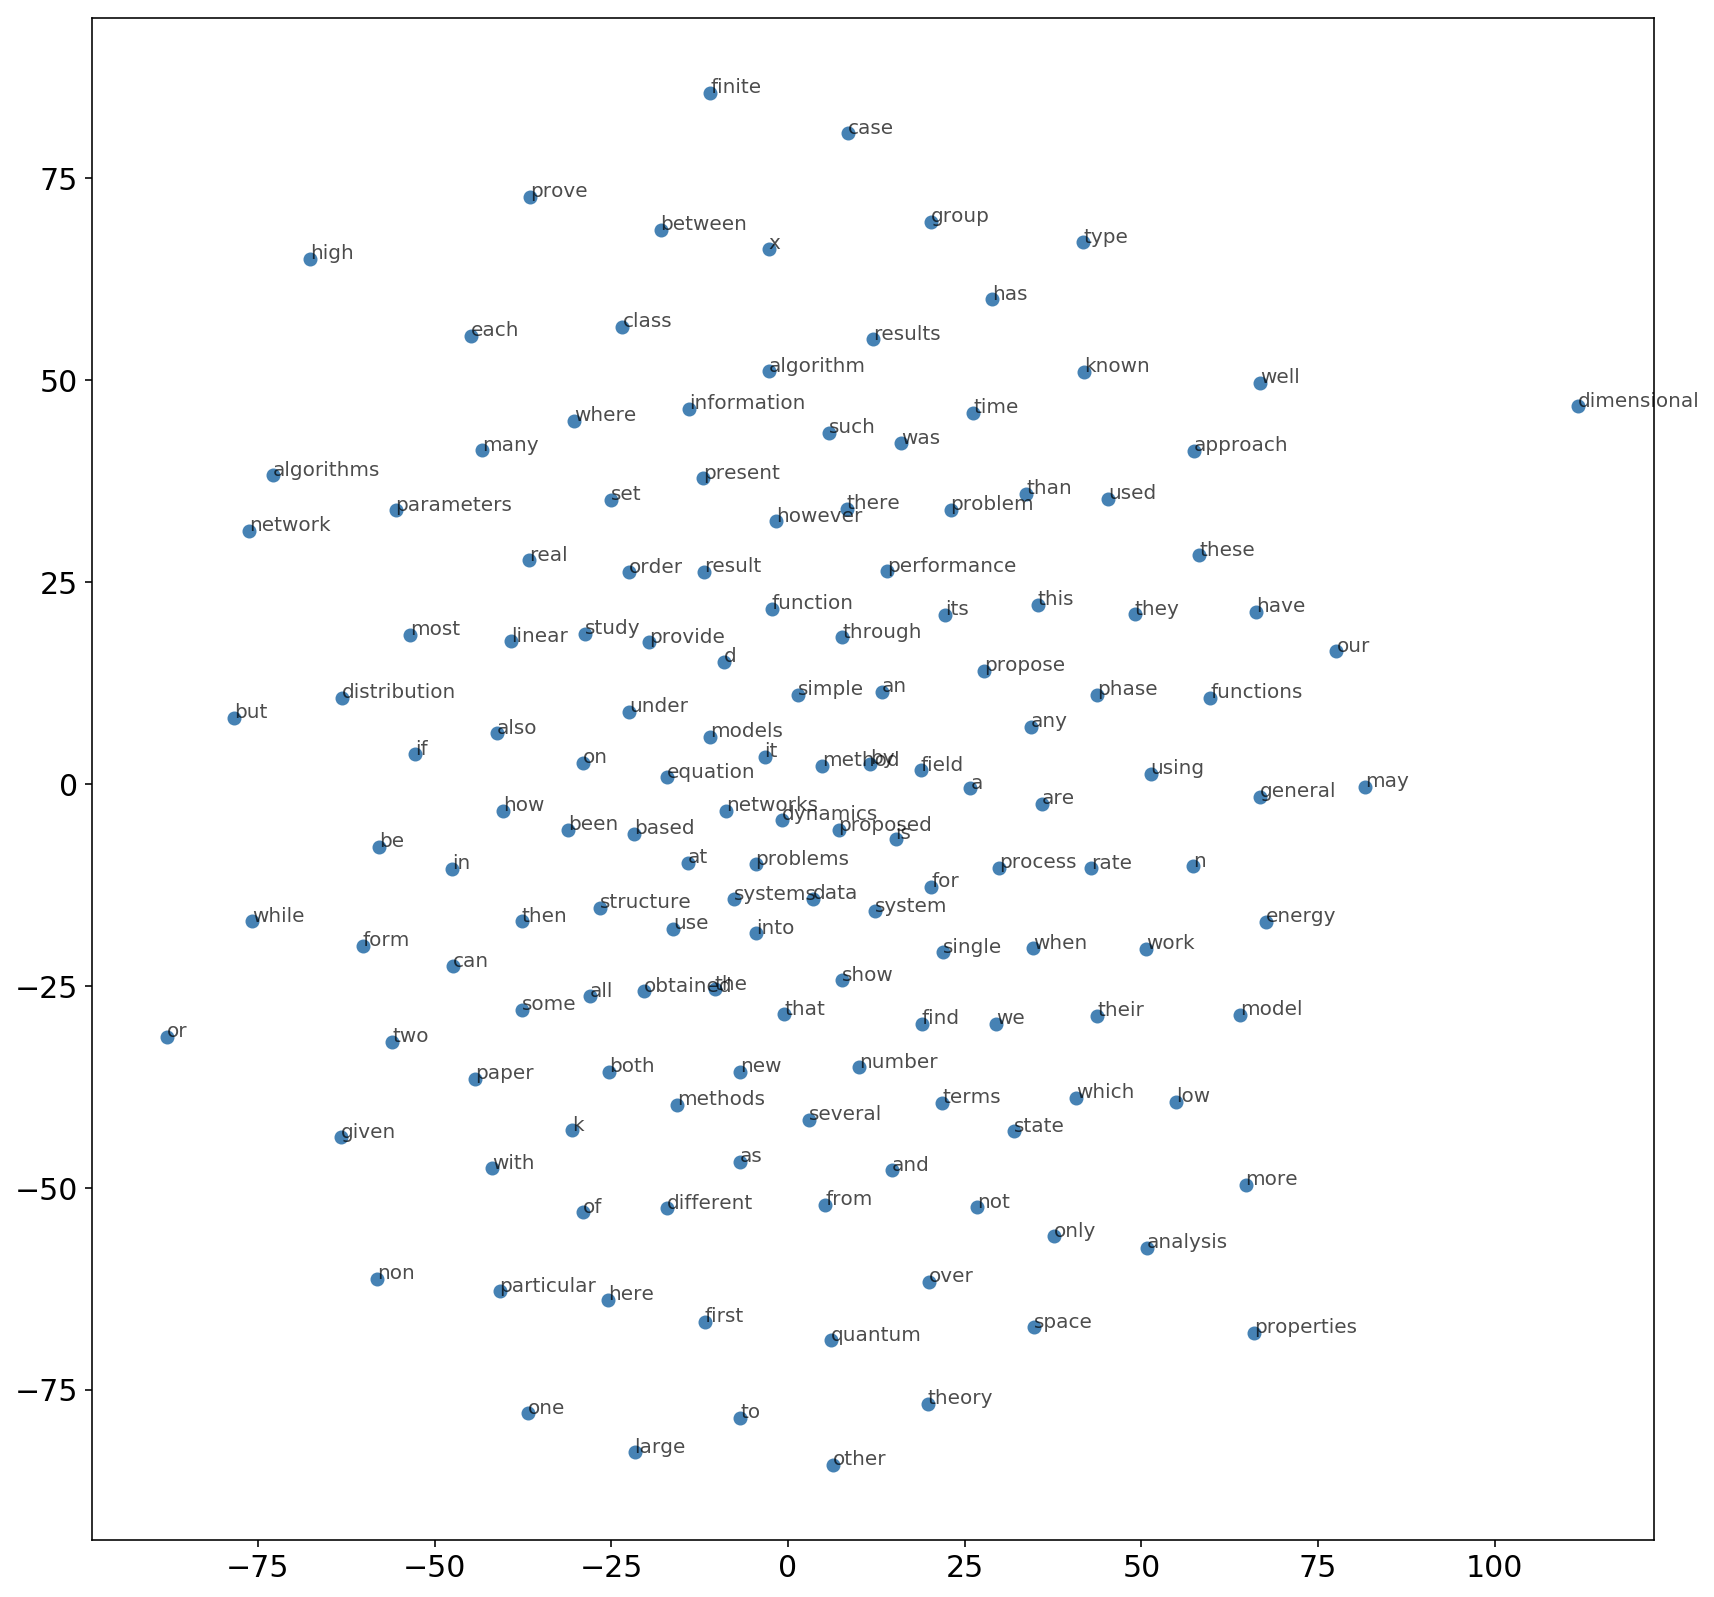

In [142]:
# Plot embedding matrix sample
with graph.as_default():
    saver = tf.train.Saver()
    
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

from sklearn.manifold import TSNE
viz_words = 150
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(1, viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

## Conclusion
The current TensorFlow models does worse than using Multinomial Naive Bayes Classification (Diego). 